In [1]:
!pip install pandas numpy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import math
rng = np.random.default_rng(42)

In [3]:
data = pd.read_csv('./mushrooms.csv')
headers = ['target', 'cap-shape',
'cap-surface',
'cap-color',
'bruises',
'odor',
'gill-attachment',
'gill-spacing',
'gill-size',
'gill-color',
'stalk-shape',
'stalk-root',
'stalk-surface-above-ring',
'stalk-surface-below-ring',
'stalk-color-above-ring',
'stalk-color-below-ring',
'veil-type',
'veil-color',
'ring-number',
'ring-type',
'spore-print-color',
'population',
'habitat']
data.columns = headers
data.describe()


,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8415,8415,8415,8415,8415,8415,8415,8415,8415,8415,...,8415,8415,8415,8415,8415,8415,8415,8415,8415,8415
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS
freq,4487,3795,3268,2320,5040,3808,8199,6824,5880,1728,...,5075,4743,4639,8415,8215,7767,3967,2424,4063,3159


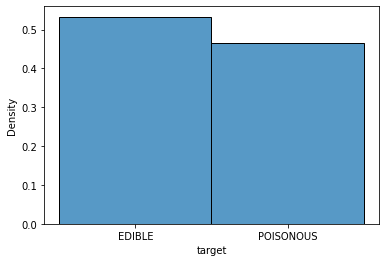

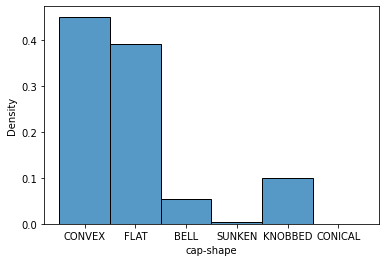

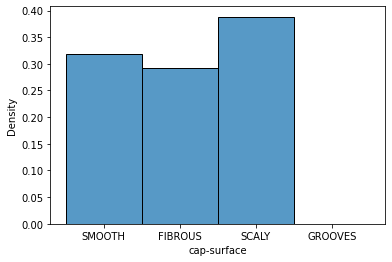

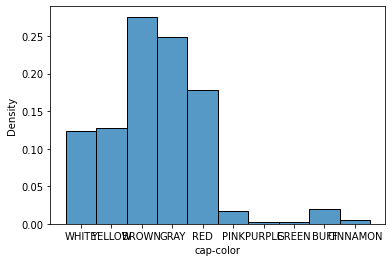

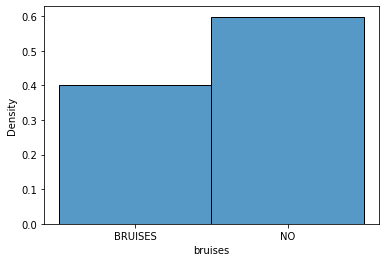

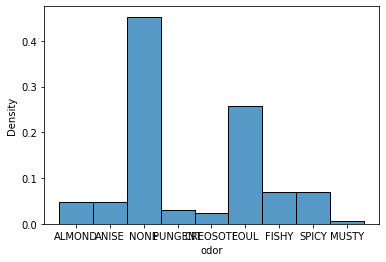

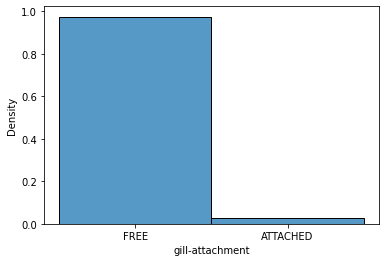

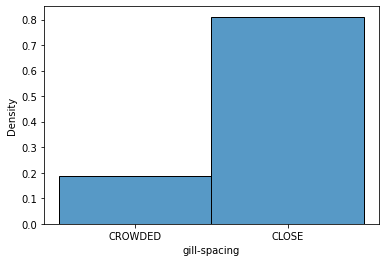

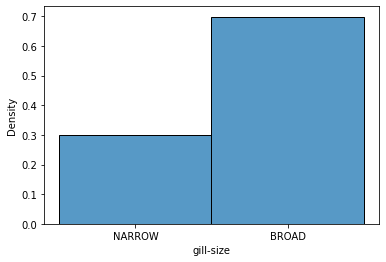

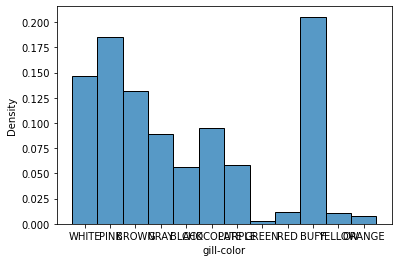

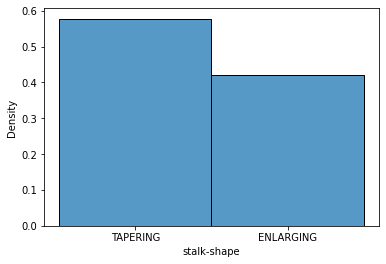

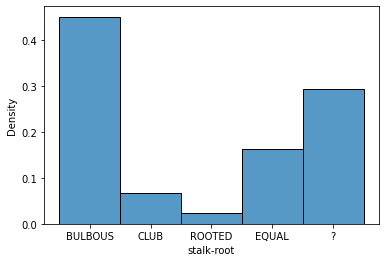

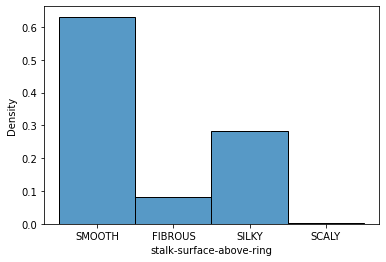

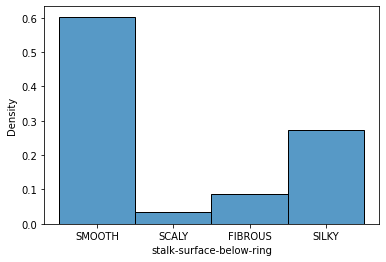

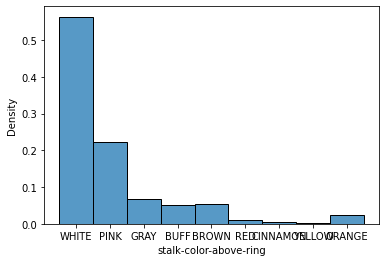

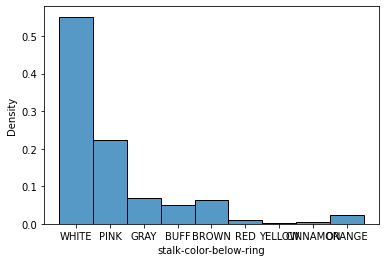

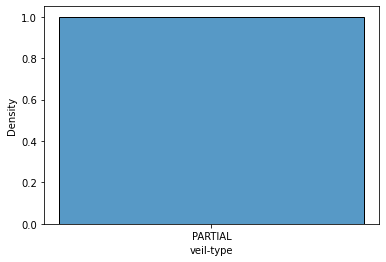

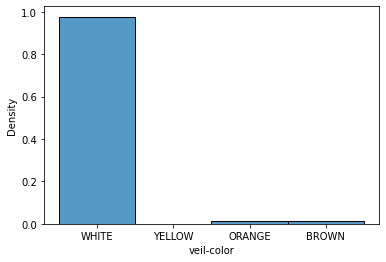

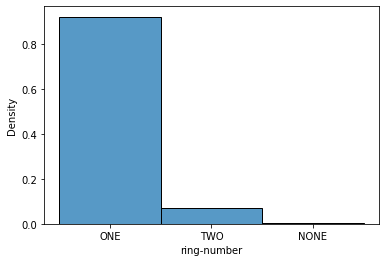

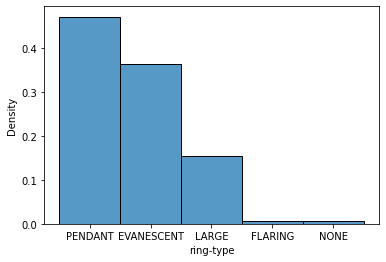

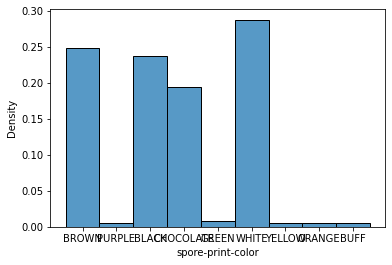

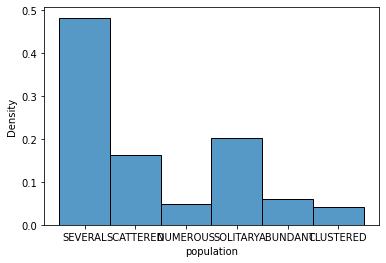

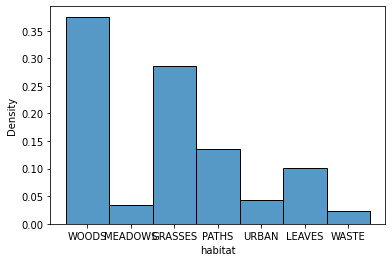

In [4]:
for i in data.columns:
    plt.figure(i)
    sns.histplot(data[i],stat="density")
    plt.show()

<AxesSubplot:>

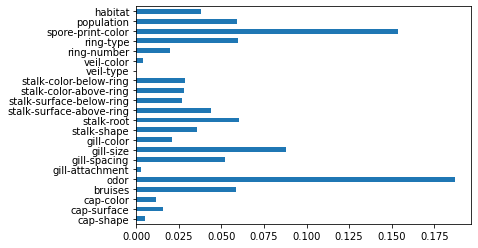

In [5]:
le = preprocessing.LabelEncoder()
for column_name in data.columns:
    data[column_name]=le.fit_transform(data[column_name])
Y=data.iloc[:, 0:1].values.ravel()
X=data.iloc[:, 1:23]

clf = RandomForestClassifier(criterion='entropy', random_state=0)
clf.fit(X, Y)

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')

In [6]:
def get_batches(data, batch_size):
    n = len(data)
    get_X = lambda z: z[0]
    get_y = lambda z: z[1]
    for i in range(1, n, batch_size):
        batch = data[i:i+batch_size]
        yield np.array([get_X(b) for b in batch]), np.array([get_y(b) for b in batch])

In [7]:
class Network:
    def mse(self, y_pred, y):
        err = np.mean(np.square(y_pred - y))
        return err

    def dmse(self, y_pred, y):
        n = y.shape[0]
        return (2/n)*(y_pred - y)
    
    # binary cross-entropy
    def bce(self, y_pred, y):
        p = y
        q = y_pred + 1e-8
        ans = (q - p)/(q * (1 - q)) + np.log((1 - q) / q)
        return np.mean(ans)
    
    # and its derivative
    def dbce(self, y_pred, y):
        p = y
        q = y_pred + 1e-8
        ans = (q - p)/(q * (1 - q)) + np.log((1 - q) / q)
        return ans
    
    def f(self, x):
        return 1/(1+np.exp(-x))
            
    def df(self, x):
        return self.f(x)*(1-self.f(x))
    
    def tanh(self, x):
        return np.tanh(x)

    def dtanh(self, x):
        return 1 - np.square(self.tanh(x))
            
    def __init__(self, architecture, batch, learning_rate):
        self.depth = len(architecture)-1
        self.batch_size = batch
        self.lr = learning_rate
    # functions
        self.activation_fn = self.tanh
        self.activation_dfn = self.dtanh
        self.loss_fn = self.mse
        self.loss_dfn = self.dmse
    # parameters
        self.W = self._init_weights(architecture)
        self.b = self._init_biases(architecture)
    # feedforward outputs
        self.z = [None] * (self.depth+1)  # before activation
        self.a = [None] * (self.depth+1)  # after activation
    # backprop gradients
        self.dW = [np.zeros_like(w) for w in self.W]
        self.db = [np.zeros_like(b) for b in self.b]
    
    # glorot uniform init
    def _init_weights(self, arch):
        net_in = arch[0]
        net_out = arch[-1]
        limit = np.sqrt(6. / (net_in + net_out))
        return [rng.uniform(0.04, 0.06, size=(arch[i+1], arch[i])) for i in range(self.depth)]
    
    def _init_biases(self, arch):
        return [rng.random((arch[i+1],1))*2-1 for i in range(self.depth)]


    def _feedforward(self, X):
        self.a[0] = X.reshape(X.shape[1], X.shape[0])
        # compute hidden and output layers
        for i in range(self.depth):
            self.z[i+1] = np.matmul(self.W[i], self.a[i]) + self.b[i]
            if i != self.depth-1:
                self.a[i+1] = self.activation_fn(self.z[i+1])
            else:
                self.a[-1] = self.z[-1]

    def _update_params(self):
        for i in range(self.depth):
            self.W[i] -= self.lr*self.dW[i]
            self.b[i] -= self.lr*self.db[i]
        
    def _compute_loss(self, X, y):
        y_pred = self.predict(X).reshape(y.shape) 
        return self.loss_fn(y_pred, y)


    def _backprop(self, y):
        d = self.loss_dfn(self.a[-1], y.T)
        for i in range(self.depth-1, 0, -1):
            if i != self.depth-1:
                d = self.activation_dfn(self.z[i+1]) * np.matmul(self.W[i+1].T, d)
            self.dW[i] = np.matmul(d, self.a[i].T)
            self.db[i] = np.sum(d, axis=1, keepdims=True)
            
    def train(self, X, y, epochs=1):
        n = y.shape[0]
        epoch_losses = np.array([])
        dataset = list(zip(X, y.T))
        for i in range(epochs):
            rng.shuffle(dataset)
            for (X_batch, y_batch) in get_batches(dataset, self.batch_size):
                self._feedforward(X_batch)
                self._backprop(y_batch)
                self._update_params()
            loss = self._compute_loss(X, y.T)
            epoch_losses = np.append(epoch_losses, loss)
        return epoch_losses


    def predict(self, X):
        a = X.reshape(22, X.shape[0])
        # compute hidden and output layers
        for i in range(self.depth): 
            a = np.matmul(self.W[i], a) + self.b[i]
            if i != self.depth-1:
                a = self.activation_fn(a)
        return a

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_560/1928419761.py:3: RuntimeWarning: overflow encountered in square
  err = np.mean(np.square(y_pred - y))
/tmp/ipykernel_560/1928419761.py:90: RuntimeWarning: overflow encountered in matmul
  d = self.activation_dfn(self.z[i+1]) * np.matmul(self.W[i+1].T, d)
/tmp/ipykernel_560/1928419761.py:90: RuntimeWarning: invalid value encountered in multiply
  d = self.activation_dfn(self.z[i+1]) * np.matmul(self.W[i+1].T, d)


First epoch loss - 137.38332049594993
Last epoch loss - nan


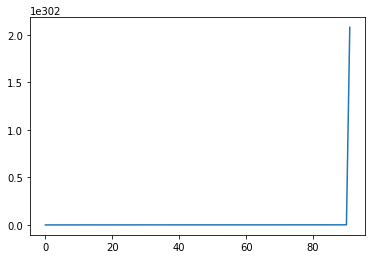

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(pd.get_dummies(np.array(y_train))).T
y_test = np.array(pd.get_dummies(np.array(y_test))).T

net_arch = (22, 14, 7, 2)
net = Network(net_arch, 100, 0.0001)
epoch_losses = net.train(X_train, y_train, epochs=150)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

In [9]:
def R_square(y_pred, y):
    y_mean = np.mean(y)
    return 1 - np.sum(np.square(y - y_pred))/np.sum(np.square(y - y_mean))

def acc(actual, predicted, label):
    tp = np.sum((actual==label) & (predicted==label))
    tn = np.sum((actual!=label) & (predicted!=label))
    return (tp+tn)/np.sum(predicted)

def prec(actual, predicted, label):
    tp = np.sum((actual==label) & (predicted==label))
    fp = np.sum((actual!=label) & (predicted==label))
    return tp/(tp+fp)

def rec(actual, predicted, label):
    tp = np.sum((actual==label) & (predicted==label))
    fp = np.sum((actual!=label) & (predicted==label))
    fn = np.sum((predicted!=label) & (actual==label))
    return tp/(tp+fn)
    
def f1(actual, predicted, label):
    precision = prec(actual, predicted, label)
    recall = rec(actual, predicted, label)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [10]:
ypred_test = net.predict(X_test)
ypred_test.reshape(2525, 2)
ypred_test = np.round(ypred_test)
print(ypred_test.shape, '\n', y_test.shape)

(2, 2525) 
 (2, 2525)


In [11]:
print('Accuracy: ', acc(y_test.T, ypred_test.T, [1, 0]))
print('Precision: ', prec(y_test.T, ypred_test.T, [1, 0]))
print('Recall: ', rec(y_test.T, ypred_test.T, [1, 0]))
print('F1: ', f1(y_test.T, ypred_test.T, [1, 0]))

Accuracy:  1.0764356435643565
Precision:  0.5382178217821783
Recall:  1.0
F1:  0.699794026776519


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Accuracy: ', accuracy_score(y_test.T, ypred_test.T ))
print('Precision: ', precision_score(y_test.T, ypred_test.T))
print('Recall: ', recall_score(y_test.T, ypred_test.T))
print('F1: ', f1_score(y_test.T, ypred_test.T))

Accuracy:  0.5382178217821783


ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].